In [178]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import norm, svds
import time
import matplotlib.pyplot as plt
import seaborn as sns


In this section, we will explore different similarity metrics Netflix uses to recommend content to users. Primarily we will explore cosine similarity and pearson correlation. 

We first begin by loading the two primary datasets, and showing what they look like. 

Shows movie dataset

In [179]:
movie_dataset = "Dataset/Netflix_Dataset_Movie.csv"
movie_df = pd.read_csv(movie_dataset)
movie_df.head()

,Movie_ID,Year,Name
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW


Shows user dataset

In [180]:
user_dataset = "Dataset/Netflix_Dataset_Rating.csv"
user_df = pd.read_csv(user_dataset)
user_df.head()

,User_ID,Rating,Movie_ID
0,712664,5,3
1,1331154,4,3
2,2632461,3,3
3,44937,5,3
4,656399,4,3


/Users/jeff/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


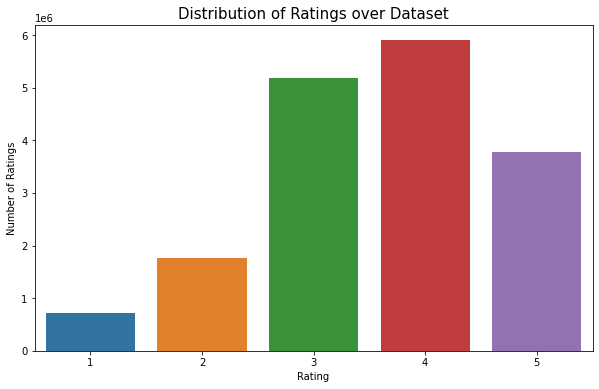

In [181]:
movie_df.dropna(inplace=True)  # Drop rows with NaN values
user_df = user_df[user_df['Rating'] != 0]  # Remove rows where rating is 0

# Basic Statistics
plt.figure(figsize=(10, 6))
plt.title('Distribution of Ratings over Dataset', fontsize=15)
sns.countplot(user_df.Rating)
plt.ylabel('Number of Ratings')
plt.show()

The below calculation shows how many movies are rated by no users in our dataset. Because these movies have 0 ratings for all users, we will exclude them from our data. Since there are 16,420 movies that are unrated, our user-movie matrix will have signicantly fewer columns than the total number of movies in the dataset.

Sparsity Reduction: Movie recommendation datasets are typically sparse, meaning most movies are not rated by most users. Removing movies that have zero ratings can significantly reduce the sparsity of our matrix, making matrix factorization techniques more effective and computationally feasible.

In [182]:
movies_in_movie_df = set(movie_df['Movie_ID'])
movies_in_user_df = set(user_df['Movie_ID'])
unrated_movies = movies_in_movie_df - movies_in_user_df

print(f"Number of movies not rated by users: {len(unrated_movies)}")

Number of movies not rated by users: 16420


Combine these two dataframe objects in order to initalize our matrix. We assume that an "unrated" movie has a rating 0 for now.

In [183]:
merged_df = pd.merge(user_df, movie_df, on='Movie_ID')
rating_matrix = merged_df.pivot_table(index='User_ID', columns='Name', values='Rating')
rating_matrix = rating_matrix.fillna(0)
rating_matrix = rating_matrix.sort_index()

In [184]:
print(f"Pivot Table Size: {rating_matrix.shape[0]} rows, {rating_matrix.shape[1]} columns")
rating_matrix.head(10)

Pivot Table Size: 143458 rows, 1342 columns


Name,10,10 Things I Hate About You,101 Dalmatians II: Patch's London Adventure,11:14,13 Ghosts,18 Again,1984,2 Fast 2 Furious,200 Cigarettes,2010: The Year We Make Contact,...,Xena: Warrior Princess: Season 3,Xena: Warrior Princess: Series Finale,Y Tu Mama Tambien,Yellow Submarine,Yi Yi,Yojimbo,Young Black Stallion,Youngblood,Yu-Gi-Oh!: The Movie,Zorro
User_ID,,,,,,,,,,,,,,,,,,,,,
6,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Running similiarity metrics on our rating matrix

Cosine similiarity: 
The cosine similarity between two vectors A and B is given by the formula: cos_similarity(A, B) = $\frac{A \cdot B}{\lVert \boldsymbol{A} \rVert \lVert \boldsymbol{B} \rVert}$

Since our dataset is large, for this technical demo, we will use the first 1,000 users to demonstrate the following similarity metrics. 

In [185]:
sample_rating_matrix = rating_matrix.head(1000)

In [186]:
def cosine_similarity(matrix):
    matrix_np = matrix.to_numpy()

    # Initialize an empty similarity matrix
    similarity_matrix = np.zeros((len(matrix), len(matrix)))

    for i in range(len(matrix)):
        for j in range(i, len(matrix)):  # Since matrix is symmetric, we only need to compute the upper half
            # Indices of non-zero elements for both users
            nz_indices_i = matrix_np[i, :] != 0
            nz_indices_j = matrix_np[j, :] != 0
            nz_indices_both = nz_indices_i & nz_indices_j

            # Vectors for computation
            vector_i = matrix_np[i, nz_indices_both]
            vector_j = matrix_np[j, nz_indices_both]

            # Skip if either vector is empty
            if len(vector_i) == 0 or len(vector_j) == 0:
                continue

            # Compute cosine similarity
            dot_product = np.dot(vector_i, vector_j)
            norm_i = np.linalg.norm(vector_i)
            norm_j = np.linalg.norm(vector_j)
            similarity = dot_product / (norm_i * norm_j)

            # Fill the similarity matrix
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity

    return similarity_matrix

In [187]:
start = time.time()
def compute_for_user(user, matrix):
    cosine_sim_matrix = cosine_similarity(matrix)

    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=matrix.index, columns=matrix.index)

    # Find the similarity values for the user and exclude user 
    similarity_with_user = cosine_sim_df[user]
    similarity_with_user = similarity_with_user.drop(user)

    # Predict ratings for user
    weighted_ratings = matrix.mul(similarity_with_user, axis=0).sum(axis=0) / similarity_with_user.sum()
    predicted_ratings = weighted_ratings

    # Exclude movies already rated by user
    unrated_movies = matrix.loc[user] == 0
    predicted_ratings_for_unrated_movies = predicted_ratings[unrated_movies]

    top_10_movies = predicted_ratings_for_unrated_movies.sort_values(ascending=False).head(10)
    return top_10_movies

top_10_movies = compute_for_user(6, sample_rating_matrix)
end = time.time()

print("Top 10 movies recommended for User 6:")
print(top_10_movies)
print("Execution time of the program is: ", end-start)


Top 10 movies recommended for User 6:
Name
American Beauty                          2.778856
Ghost                                    2.221978
Speed                                    1.930027
The Wizard of Oz: Collector's Edition    1.882315
Jaws                                     1.869414
Being John Malkovich                     1.860085
Patch Adams                              1.825309
Bend It Like Beckham                     1.821213
Sideways                                 1.786273
National Lampoon's Vacation              1.747065
dtype: float64
Execution time of the program is:  25.905619859695435


In [188]:
def cosine_similarity_optimized(matrix):
    # Convert to sparse matrix
    sparse_matrix = csr_matrix(matrix)

    # Compute the magnitude for each user vector
    magnitude = norm(sparse_matrix, axis=1)

    # Normalize each vector to unit norm
    unit_matrix = sparse_matrix.multiply(1 / magnitude.reshape(-1, 1))

    # Compute cosine similarity
    return unit_matrix.dot(unit_matrix.T).toarray()

In [189]:
start = time.time()
def compute_for_user(user, matrix):
    # Calculate the cosine similarity matrix
    cosine_sim_matrix = cosine_similarity_optimized(matrix)

    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=matrix.index, columns=matrix.index)

    # Find the similarity values for user and exclude user 
    similarity_with_user = cosine_sim_df[user]
    similarity_with_user = similarity_with_user.drop(user)

    # Predict ratings for user
    weighted_ratings = matrix.mul(similarity_with_user, axis=0).sum(axis=0) / similarity_with_user.sum()
    predicted_ratings = weighted_ratings

    # Exclude movies already rated by user
    unrated_movies = matrix.loc[user] == 0
    predicted_ratings_for_unrated_movies = predicted_ratings[unrated_movies]

    top_10_movies = predicted_ratings_for_unrated_movies.sort_values(ascending=False).head(10)
    return top_10_movies

top_10_movies = compute_for_user(6, sample_rating_matrix)
end = time.time()

print("Top 10 movies recommended for User 6:")
print(top_10_movies)
print("Execution time of the program is:  ", end-start)



Top 10 movies recommended for User 6:
Name
American Beauty                          2.871258
Ghost                                    2.326168
Speed                                    2.084855
Jaws                                     2.014155
The Wizard of Oz: Collector's Edition    1.964019
Patch Adams                              1.918758
Being John Malkovich                     1.902401
Sideways                                 1.891653
National Lampoon's Vacation              1.890831
Bend It Like Beckham                     1.845176
dtype: float64
Execution time of the program is:   0.17526912689208984


As you can see from the output of my two cosine_similarity functions, the results are slightly different - the #1 suggested movie of American beautiy has a "score" of 2.77 in the first result and 2.88 in the second. The Wizard of Oz is the 4th recommended movie in the first implementation while it is 5th in the second implementation. 

Reasons for slight differences: 

a. Treatment of Zeros:

In the dense implementation (cosine_similarity), zeros are explicitly considered and filtered out for each pair of users being compared. This method calculates similarity based solely on the items that both users have rated.
The sparse implementation (cosine_similarity_optimized) inherently ignores zeros since they are not stored in the sparse matrix format. This method focuses on the non-zero ratings but might include zeros in the normalization step across entire vectors.

b. Normalization Process:

The first method normalizes vectors by considering only non-zero elements, effectively altering the vector length during normalization. This approach changes the basis of comparison to focus strictly on commonly rated items.
The sparse method normalizes each vector as a whole, including zeros. This can lead to a slightly different interpretation of user preferences, especially in rows with many zeros.

While there are technical differences in how the dense and sparse implementations of cosine similarity handle the data, especially regarding zeros and normalization, these differences are usually minor in the context of a recommendation system. The primary goal is to identify general patterns of user preferences, and both methods effectively contribute to this goal, with the sparse method offering significant computational advantages (as you can tell by the total time it took the program to run).

 The Pearson correlation coefficient is a measure of the linear correlation between two sets of data. In the context of a rating matrix where rows represent users and columns represent movies, the Pearson correlation can be used to measure the similarity between users based on their movie ratings.

Below is a naive implemenation of what a pearson_correlation looks like. Since there are many useful libraries to assit this, I will be using the library the "corr = pearson" provided by pandas in the future. 

(in a matrix with N users and M movies)
Calculating Mean for Each User: The mean of the ratings needs to be computed for each user. This step involves summing up M ratings and then dividing by M. The time complexity for this step is O(M) for each user. Since there are N users, the total time complexity for this step is O(NM).

Calculating Pearson Correlation for Each Pair of Users: For each pair of users, the Pearson correlation is calculated. This involves iterating over each of the M ratings for both users, performing some arithmetic operations, and then dividing the result. The time complexity for comparing a single pair of users is O(M). There are $N(N-1)/2$ pairs , so the total time complexity is $O(N^2M)$

In [190]:
def mean(data):
    return sum(data) / len(data)

def pearson_correlation(user1_ratings, user2_ratings):
    # ensure both users have rated the same number of movies
    if len(user1_ratings) != len(user2_ratings):
        return None

    mean_user1 = mean(user1_ratings)
    mean_user2 = mean(user2_ratings)

    # Numerator and denominator for the Pearson correlation formula
    numerator = sum((x - mean_user1) * (y - mean_user2) for x, y in zip(user1_ratings, user2_ratings))
    denominator_part1 = sum((x - mean_user1) ** 2 for x in user1_ratings)
    denominator_part2 = sum((y - mean_user2) ** 2 for y in user2_ratings)

    # If the denominator is 0, return None (no correlation)
    if denominator_part1 == 0 or denominator_part2 == 0:
        return None

    return numerator / (denominator_part1 ** 0.5 * denominator_part2 ** 0.5)

user1 = [4, 5, 3, 2]
user2 = [5, 3, 4, 1]

correlation = pearson_correlation(user1, user2)
print(f"Pearson Correlation: {correlation}")


Pearson Correlation: 0.529150262212918


In [191]:
def top_similar_users(target_user_id, user_item_matrix, top_n=50):
    target_user_ratings = user_item_matrix.loc[target_user_id]
    similarities = {}

    for user_id in user_item_matrix.index:
        if user_id != target_user_id:
            current_user_ratings = user_item_matrix.loc[user_id]
            correlation = target_user_ratings.corr(current_user_ratings, method='pearson')
            if not np.isnan(correlation):
                similarities[user_id] = correlation

    # Sort users based on similarity score
    top_users = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_users

In [192]:
similar_users = top_similar_users(6, sample_rating_matrix)  
print(similar_users[:10])

[(14936, 0.5485083619604826), (11676, 0.4955740991284069), (15731, 0.4761117520680235), (12582, 0.4450406933646307), (1295, 0.44192122501171854), (12649, 0.44102348047097184), (11826, 0.4388587845159367), (3695, 0.43408143858588255), (17949, 0.43180055561791314), (15385, 0.4253822626811486)]


In [193]:
def recommend_movies(similar_users, user_item_matrix, top_n=50):
    movie_scores = {}

    for user_id, score in similar_users:
        for movie_id, rating in user_item_matrix.loc[user_id].items():
            if not np.isnan(rating):
                if movie_id not in movie_scores:
                    movie_scores[movie_id] = rating * score
                else:
                    movie_scores[movie_id] += rating * score

    # Sort movies based on the calculated score
    recommended_movies = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return recommended_movies


In [194]:
recommended_movies = recommend_movies(similar_users, sample_rating_matrix)
print(recommended_movies)


[('Braveheart', 87.30697294393387), ('Lord of the Rings: The Fellowship of the Ring', 87.2287854301782), ('Pirates of the Caribbean: The Curse of the Black Pearl', 84.86232239891373), ('The Last Samurai', 84.43133165039265), ('The Sixth Sense', 82.65357158903699), ('The Silence of the Lambs', 81.14449728468459), ('Shrek 2', 80.02766775391659), ('The Bourne Supremacy', 76.4850865451375), ('Road to Perdition', 75.30331151790745), ('The Italian Job', 74.11938967619633), ('Finding Nemo (Widescreen)', 73.92022593358918), ('Man on Fire', 73.24230712979208), ('The Matrix: Reloaded', 70.37241729941994), ('Lethal Weapon', 70.17846940076505), ('Bruce Almighty', 69.15493479581113), ('A Beautiful Mind', 68.86758316218906), ('Ray', 68.64324538418771), ('American Beauty', 68.07248455109773), ('Kill Bill: Vol. 2', 67.60178135761747), ('50 First Dates', 65.6867789239527), ('Reservoir Dogs', 65.49500477157736), ('The Godfather', 64.49813469329442), ('The Passion of the Christ', 64.25628193798171), ('Th

Now we test how good our metrics are at "predicting" ratings. In order to do this, we use the following methodology:

Take a sample user X. Find movies he has previously watched, and rated and store them somewhere.
We now set these ratings to "0" (as if it were never rated)
Run the tests to "fill in" these values and then compare it to what the user actually rated it as. 

In [205]:
test_user = 6
test_matrix = rating_matrix.head(20_000)

actual_ratings = {}

for rating in range(1, 6):
    rated_movies = test_matrix.loc[test_user]
    selected_movies = rated_movies[rated_movies == rating].sample(n=4, replace=True)
    actual_ratings.update(selected_movies.to_dict())
actual_ratings


user_item_matrix_mod = test_matrix.copy()
user_item_matrix_mod.loc[test_user, actual_ratings.keys()] = np.NaN

slightly adjust our cosine simliarity function using the same logic I have demonstrated above: 

In [206]:
def cosine_similarity_optimized(matrix):
    sparse_matrix = csr_matrix(matrix.fillna(0))
    magnitude = norm(sparse_matrix, axis=1)
    unit_matrix = sparse_matrix.multiply(1 / magnitude.reshape(-1, 1))
    return unit_matrix.dot(unit_matrix.T).toarray()

def compute_for_user(user, matrix):
    cosine_sim_matrix = cosine_similarity_optimized(matrix)
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=matrix.index, columns=matrix.index)
    similarity_with_user = cosine_sim_df[user].drop(user)
    weighted_ratings = matrix.mul(similarity_with_user, axis=0).sum(axis=0) / similarity_with_user.sum()
    predicted_ratings = weighted_ratings[actual_ratings.keys()]
    return predicted_ratings

cosine_predicted_ratings = compute_for_user(test_user, user_item_matrix_mod)


In [207]:
def top_similar_users(user_id, matrix, n=20):
    target_user_ratings = matrix.loc[user_id]
    similarities = {}
    for other_user in matrix.index:
        if other_user != user_id:
            other_user_ratings = matrix.loc[other_user]
            correlation = target_user_ratings.corr(other_user_ratings, method='pearson')
            if not np.isnan(correlation):
                similarities[other_user] = correlation
    top_users = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:n]
    return top_users

def predict_pearson_ratings(user_id, matrix, top_users):
    pearson_predictions = {}
    for movie in actual_ratings.keys():
        weighted_ratings_sum = 0
        similarity_sum = 0
        for other_user, similarity in top_users:
            if not np.isnan(matrix.loc[other_user, movie]):
                weighted_ratings_sum += matrix.loc[other_user, movie] * similarity
                similarity_sum += similarity
        predicted_rating = weighted_ratings_sum / similarity_sum if similarity_sum != 0 else 0
        pearson_predictions[movie] = predicted_rating
    return pearson_predictions

top_users = top_similar_users(test_user, user_item_matrix_mod)
pearson_predicted_ratings = predict_pearson_ratings(test_user, user_item_matrix_mod, top_users)


In [208]:
movies = list(actual_ratings.keys())
actual_ratings_list = [actual_ratings[movie] for movie in movies]
cosine_ratings_list = [cosine_predicted_ratings.get(movie, None) for movie in movies]
pearson_ratings_list = [pearson_predicted_ratings.get(movie, None) for movie in movies]


We now plot the results : the x axis represent what the user we are testing actually rated those users, and the y axis represents how different similarity metrics "predict" what the user would have ranked it. 

In [209]:
def plot_actual_vs_cosine(actual_ratings, cosine_predicted_ratings, movies):
    plt.figure(figsize=(10, 5))
    plt.scatter(actual_ratings, cosine_predicted_ratings, color='blue')
    plt.title('Actual vs Cosine Predicted Ratings')
    plt.xlabel('Actual Ratings')
    plt.ylabel('Cosine Predicted Ratings')
    plt.xticks(range(1, 6))
    plt.yticks(range(1, 6))
    for i, txt in enumerate(movies):
        plt.annotate(txt, (actual_ratings[i], cosine_predicted_ratings[i]))
    plt.show()


In [210]:
def plot_actual_vs_pearson(actual_ratings, pearson_predicted_ratings, movies):
    plt.figure(figsize=(10, 5))
    plt.scatter(actual_ratings, pearson_predicted_ratings, color='green')
    plt.title('Actual vs Pearson Predicted Ratings')
    plt.xlabel('Actual Ratings')
    plt.ylabel('Pearson Predicted Ratings')
    plt.xticks(range(1, 6))
    plt.yticks(range(1, 6))
    for i, txt in enumerate(movies):
        plt.annotate(txt, (actual_ratings[i], pearson_predicted_ratings[i]))
    plt.show()


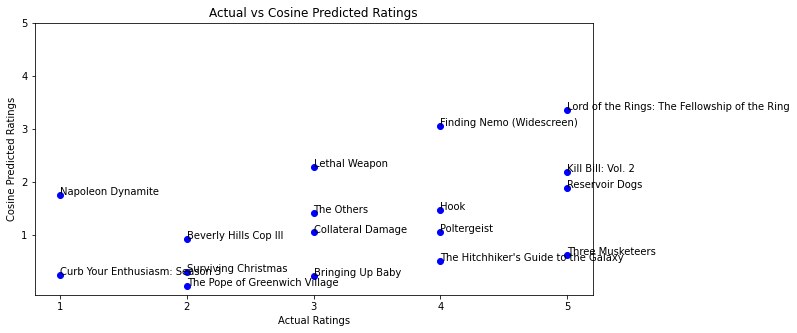

In [211]:
plot_actual_vs_cosine(actual_ratings_list, cosine_ratings_list, movies)



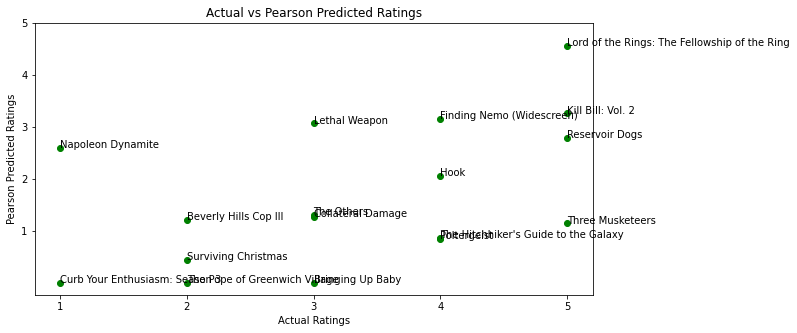

In [212]:
plot_actual_vs_pearson(actual_ratings_list, pearson_ratings_list, movies)


In [213]:
#this method is implenent in full in the other file titled matricFactorization ->
#here we simply use a built in library for testing purposees
def recommend_movies_svd(rating_matrix, user_id, num_recommendations=10):

    matrix = rating_matrix.fillna(0).to_numpy()
    
    U, sigma, Vt = svds(matrix, k=50)  
    sigma = np.diag(sigma)

    predicted_ratings = np.dot(np.dot(U, sigma), Vt)

    pred_ratings_df = pd.DataFrame(predicted_ratings, index=rating_matrix.index, columns=rating_matrix.columns)

    user_row_number = user_id - 1 
    sorted_user_predictions = pred_ratings_df.iloc[user_row_number].sort_values(ascending=False)
    
    user_data = rating_matrix.loc[user_id]
    recommendations = sorted_user_predictions[~sorted_user_predictions.index.isin(user_data[user_data > 0].index)]
    
    return recommendations.head(num_recommendations)

num_recommendations = 10
recommendations = recommend_movies_svd(test_matrix, test_user, num_recommendations)
print(recommendations)

Name
Patch Adams         3.544716
Speed               3.220768
Rush Hour 2         2.955647
Ghost               2.880152
The Family Man      2.848154
Jaws                2.814324
Secondhand Lions    2.680317
Pay It Forward      2.677584
American Beauty     2.553648
Garden State        2.534239
Name: 169, dtype: float64


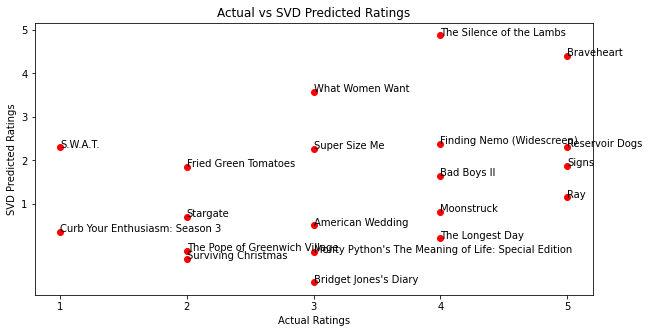

In [232]:
test_user = 6
num_movies_to_test = 10 

actual_ratings = {}
for rating in range(1, 6):
    rated_movies = test_matrix.loc[test_user]
    selected_movies = rated_movies[rated_movies == rating].sample(n=5, replace=True)  
    actual_ratings.update(selected_movies.to_dict())

user_item_matrix_mod = test_matrix.copy()
user_item_matrix_mod.loc[test_user, actual_ratings.keys()] = np.NaN

predicted_ratings_full = recommend_movies_svd(user_item_matrix_mod, test_user, len(test_matrix.columns))
predicted_ratings = predicted_ratings_full.loc[actual_ratings.keys()]

movies = list(actual_ratings.keys())
actual_ratings_list = list(actual_ratings.values())
predicted_ratings_list = predicted_ratings.tolist()

plt.figure(figsize=(10, 5))
plt.scatter(actual_ratings_list, predicted_ratings_list, color='red')
plt.title('Actual vs SVD Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('SVD Predicted Ratings')
plt.xticks(range(1, 6))
plt.yticks(range(1, 6))
for i, txt in enumerate(movies):
    plt.annotate(txt, (actual_ratings_list[i], predicted_ratings_list[i]))
plt.show()